# Oriana Felszer: 
### 345143655

# Aron Bensimhon: 
### 342762689

Github URL: https://github.com/orifelszer/MachineLearning/blob/main/car_prediction%20(4).ipynb

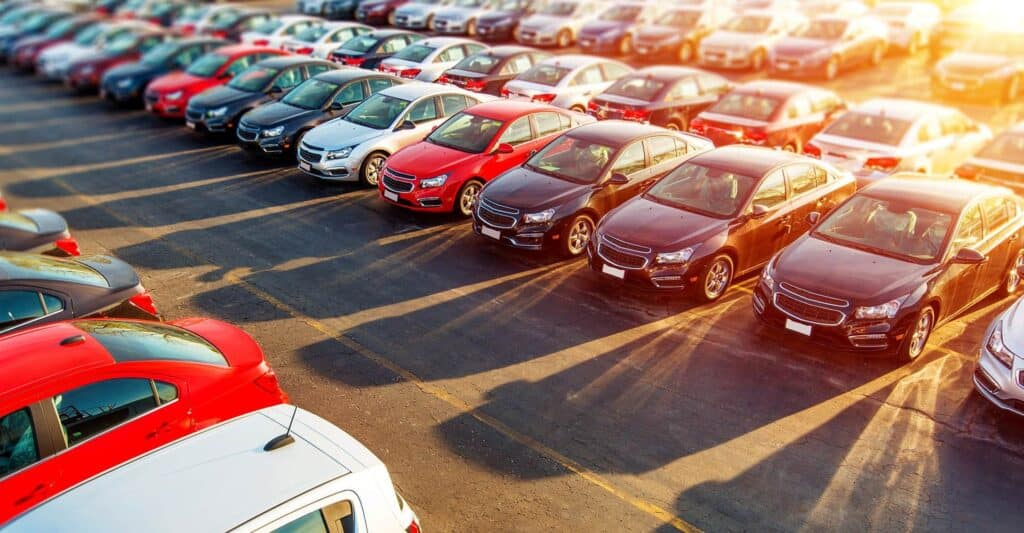

In [1]:
from IPython.display import Image, display
image_path = '/Users/user/Downloads/Used-Car-Dealer-Near-Hoover-1024x533.jpg'
display(Image(filename=image_path))


## Car Price Prediction Model

This notebook contains a machine learning model for predicting car prices based on various features.

## Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

## Data Preparation

### Function: prepare_data

This function preprocesses the training data by:
* Removing irrelevant columns
* Converting data types
* Handling missing values
* Creating new features

In [3]:
def prepare_data(X: pd.DataFrame):
    """
    preprocess training data.
    Parameter
    ----------
    X: pd.DataFrame
        the loaded data
    Returns
    -------
    A clean, preprocessed version of the data
    """
    df = X
    # remove irrelevant columns
    COL_TO_REMOVE = ["Cre_date", "Repub_date", "Area", "City",
                     "Pic_num", "Supply_score", "Test"]
    df = df.drop(COL_TO_REMOVE, axis=1)
    # Convert columns to appropriate types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Price'] = pd.to_numeric(df['Price'].replace(r'[^\d.]', '', regex=True), errors='coerce')
    df['Km'] = pd.to_numeric(df['Km'].replace(r'[^\d.]', '', regex=True), errors='coerce')
    df['capacity_Engine'] = pd.to_numeric(df['capacity_Engine'].replace(r'[^\d.]', '', regex=True), errors='coerce')

    # Handle missing values in 'Curr_ownership'
    df['Curr_ownership'] = df['Curr_ownership'].replace('', 'לא מוגדר').fillna('לא מוגדר')
    df['Prev_ownership'] = df['Prev_ownership'].replace('', 'לא מוגדר').fillna('לא מוגדר')

    # Ownership history
    df['Ownership_Change'] = (df['Prev_ownership'] != df['Curr_ownership']).astype(int)
    df['Is_Private'] = ((df['Curr_ownership'] == 'פרטית') & (df['Prev_ownership'] == 'פרטית')).astype(int)

    # This column effectively flags whether the ownership status of a car was private in both the current and previous ownership records.
    # 'Ownership_Change'  indicates if the car has been resold, which could affect its value.
    # 'Is_Private'  is relevant because privately owned cars might be treated differently thus less decreasing the car's value.

    keyword_df = df['Description'].apply(check_keywords).apply(pd.Series)
    df = pd.concat([df, keyword_df], axis=1)
    # The values in this dataframe are 1 or 0, indicating presence or absence of each keyword.

    # Convert 'capacity_Engine' to numeric
    df['capacity_Engine'] = df['capacity_Engine'].astype(str).str.replace(',', '')
    df['capacity_Engine'] = pd.to_numeric(df['capacity_Engine'], errors='coerce')

    # Fill missing 'capacity_Engine' with the median
    df['capacity_Engine'] = df.groupby('manufactor')['capacity_Engine'].transform(lambda x: x.fillna(x.median()))
    overall_median = df['capacity_Engine'].median()
    df['capacity_Engine'].fillna(overall_median, inplace=True)

    # Ensure 'capacity_Engine' is of type int
    df['capacity_Engine'] = df['capacity_Engine'].astype(int)
    model_capacity_map = {
        'אפלנדר': 3880,
        'סקודה אוקטביה ספייס\r\n (2015)': 1200,
        "אלפא רומיאו ג'ולייטה": 1368,
        'טראקס': 1600,
        "M1": 1998,
        'פיקנטו': {13: 1300, 125: 1250},
        'רנו פלואנס חשמלי': 1461,
        "אטראז'": 1248,
        "פאביה": 999,
        "3": 1598,
        "סונטה": 999,
        "סקודה אוקטביה (2016)": 1200,
        "C1": 998
    }
    df = filter_by_condtion(df, model_capacity_map)
    # Fill missing 'Engine_type' with the mode
    if not df['Engine_type'].mode().empty:
        df['Engine_type'].fillna(df['Engine_type'].mode()[0], inplace=True)

    # Fill missing 'Color' with mode within groups
    df['Color'] = df.groupby(['manufactor', 'model'])['Color'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

    # Simplify the colors of the cars
    df = color_mapping(df)
    df['model'] = df['model'].apply(remove_year_from_model)
    # Apply corrections to 'model' column
    df['model'] = df['model'].apply(apply_corrections)
    # Creating a new 'Horsepower' column by applying the estimate_horsepower function to each row
    df['Horsepower'] = df.apply(lambda row: estimate_horsepower(row['capacity_Engine'], row['Engine_type']), axis=1)
    # Transmission type
    df['Is_Automatic'] = (df['Gear'] == 'אוטומטית').astype(int)
    return df


### Helper Functions

We use several helper functions in the data preparation process:

* `check_keywords`: Checks for specific keywords in the car description
* `estimate_horsepower`: Estimates horsepower based on engine capacity and type
* `apply_corrections`: Corrects and standardizes model names
* `remove_year_from_model`: Removes the year from model names
* `filter_by_condtion`: Filters data based on specific conditions
* `color_mapping`: Simplifies and categorizes car colors

In [4]:
def check_keywords(description):
    #  returns a dictionary where each keyword is a key, and the value is 1 if the keyword is found in the description (case-insensitive), or 0 if not.
    keywords = ['שמור', 'תאונה', 'מטופל', 'חדש']
    return {keyword: int(keyword in str(description).lower()) for keyword in keywords}


# Create Horsepower column
def estimate_horsepower(capacity, engine_type):
    if pd.isna(capacity):
        return np.nan
    if engine_type == 'בנזין':  # Petrol
        return capacity * 0.1
    elif engine_type == 'דיזל':  # Diesel
        return capacity * 0.08
    elif engine_type == 'חשמלי':  # Electric
        return capacity * 1.34  # Assuming capacity is in kW for electric
    else:
        return capacity * 0.09  # Default multiplier for unknown engine types

#This function provides a rough estimate of horsepower based on engine capacity and type.
#It creates a standardized 'Horsepower' feature, which can be more informative than separate 'capacity' and 'engine_type' features.


# Function that corrects the model names
def apply_corrections(model):
    corrections = [
        ('אודי', 'אאודי'),
        ('סקודה אוקטביה ספייס\s*', 'סקודה אוקטביה ספייס'),
        ('אאודי A(\d)', r'אאודי A\1'),
        ('סקודה פאביה\s*', 'סקודה פאביה'),
        ('סקודה רומסטר\s*', 'סקודה רומסטר'),
        ('אאודי RS(\d)', r'אאודי RS\1'),
        ('ג`טה', 'ג\'טה'),
        ('ג\'אז', 'ג`אז'),
        ('אוונסיס', 'אונסיס'),
        ('גראנד, וויאג`ר', 'גראנד, וויאג\'ר'),
    ]
    for pattern, replacement in corrections:
        model = re.sub(pattern, replacement, model)
    return model


# Removes the year from model names
def remove_year_from_model(model):
    return re.sub(r'\b20\d{2}\b', '', model)


def filter_by_condtion(df, model_capacity_map):
    def matches_condition(model, capacity):
        if model in model_capacity_map:
            condition = model_capacity_map[model]
            if isinstance(condition, dict):
                return capacity in condition.values()
            else:
                return capacity == condition
        return True

    return df[df.apply(lambda row: matches_condition(row['model'], row['capacity_Engine']), axis=1)]


def color_mapping(df):
    # Define the mapping of colors to simplified categories
    color_map = {
        'לבן': 'White',
        'שחור': 'Dark',
        'כסף': 'Silver',
        'אפור': 'Grey',
        'כחול': 'Blue',
        'אדום': 'Red',
        'ירוק': 'Green',
        'צהוב': 'Yellow',
        'כתום': 'Orange',
        'חום': 'Brown',
        'בורדו': 'Red',
        'סגול': 'Purple',
        'זהב': 'Gold',
        'פלטינום': 'Silver',
        'אחר': 'Other',
        'לילך': 'Purple',
        'טורקיז': 'Blue',
        'פנינה': 'white',
        'בז`': 'Beige',
        'תכלת': 'Blue',
        'קרם': 'White',
        'ורוד': 'Pink',
        'אינדיגו': 'Blue',
        'יין': 'Red'
    }
    df['Color'] = df['Color'].map(color_map).fillna('Other')
    return df


## Main Execution

### Data Preparation and Feature Engineering

- **Loading and Preparing Data:** Reads a CSV file containing car dataset and prepares it for analysis.
- **Extracting Features:** Separates the dataset into features (`X`) and target variable (`y`).
- **Defining Features:** Specifies numeric and categorical features used in the analysis.


In [5]:
# Load data and prepare it
df = pd.read_csv('/Users/user/Downloads/dataset (1).csv')
df = prepare_data(df)

# Extract features and target variable
X = df.drop('Price', axis=1)
y = df['Price']

# Define numeric and categorical features
numeric_features = ['Year', 'Km', 'Horsepower', 'Is_Automatic', 'Ownership_Change', 'Is_Private',
                    'שמור', 'תאונה', 'מטופל', 'חדש']
categorical_features = ['manufactor', 'model', 'Hand', 'Engine_type', 'Color']

### Preprocessing and Feature Transformation

- **Preprocessing Categorical Features:** Converts categorical features into dummy variables (`X_categorical`).
- **Combining Processed Features:** Merges preprocessed numeric and categorical features into a unified dataset (`X_processed`).

In [6]:
# Preprocess categorical features
X_categorical = pd.get_dummies(X[categorical_features], drop_first=True)

# Preprocess numeric features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_numeric = numeric_transformer.fit_transform(X[numeric_features])

# Combine processed numeric and categorical features
X_processed = np.concatenate((X_numeric, X_categorical), axis=1)


### Model Training and Evaluation

- **Grid Search:** Uses cross-validated grid search to find optimal hyperparameters (`alpha` and `l1_ratio`) for ElasticNet regression.
- **Model Selection:** Initializes and fits an ElasticNet model with the best parameters.
- **Performance Metrics:** Calculates and displays RMSE and R-squared scores to evaluate model performance on the entire dataset.

In [7]:
# Grid Search with Cross-Validation to find the best alpha and l1_ratio
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'l1_ratio': [0.0, 0.1, 0.5, 0.7, 1.0]
}

elastic_net = ElasticNet()
grid_search = GridSearchCV(elastic_net, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_processed, y)

best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

print(f"Best Alpha: {best_alpha}")
print(f"Best L1 Ratio: {best_l1_ratio}")

# Initialize ElasticNet model with best parameters
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)

# Fit the model
elastic_net.fit(X_processed, y)

# Predict on the entire dataset
y_pred = elastic_net.predict(X_processed)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")


Best Alpha: 0.001
Best L1 Ratio: 0.1
RMSE: 10303.67
R-squared: 0.78


### Cross-Validation and Feature Importance Analysis

- **Cross-Validation:** Conducts 10-fold cross-validation to assess model performance using RMSE scores.
- **Feature Importance Analysis:** Determines the importance and impact of features on predicting car prices using ElasticNet coefficients.

In [8]:
# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(elastic_net, X_processed, y, cv=kf, scoring='neg_mean_squared_error')
cross_val_rmse_scores = np.sqrt(-cross_val_scores)

print(f"Cross-Validation RMSE scores: {cross_val_rmse_scores}")
print(f"Mean Cross-Validation RMSE: {cross_val_rmse_scores.mean():.2f}")
print(f"Standard Deviation of Cross-Validation RMSE: {cross_val_rmse_scores.std():.2f}")

# Feature importance for ElasticNet (coefficient magnitude)
feature_names = numeric_features + list(X_categorical.columns)

# Create feature groups dictionary
feature_groups = {}
for feature in categorical_features:
    dummies = [col for col in X_categorical.columns if col.startswith(feature)]
    for dummy in dummies:
        feature_groups[dummy] = feature

#Allows us to group the dummy variables back to their original categorical features, providing a more meaningful analysis of feature importance for categorical variables.   
        
# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(elastic_net.coef_)
})

# Group importances
grouped_importance = feature_importance.groupby(
    feature_importance['feature'].map(lambda x: feature_groups.get(x, x))
).sum().sort_values('importance', ascending=False)

# Calculate impact
grouped_importance['impact'] = 'Neutral'  # Default value

for index in grouped_importance.index:
    mask = feature_importance['feature'].map(lambda x: feature_groups.get(x, x)) == index
    if mask.any():
        relevant_features = feature_importance.loc[mask, 'feature']
        relevant_coefs = [elastic_net.coef_[feature_names.index(feat)] for feat in relevant_features]
        coef_sum = (feature_importance.loc[mask, 'importance'] * np.sign(relevant_coefs)).sum()
        grouped_importance.loc[index, 'impact'] = 'Positive' if coef_sum >= 0 else 'Negative'

print("\nTop 5 most important grouped features with impact:")
for index, row in grouped_importance.head(5).iterrows():
    feature = index
    importance = row['importance']
    impact = row['impact']
    print(f"{feature}: {importance:.4f} ({impact})")


Cross-Validation RMSE scores: [12493.75939474 16327.77125711 18304.20125135 21145.40148716
 12175.30373267 10758.06869128  9828.02002723 11204.52234962
 13127.37160949 12580.97123764]
Mean Cross-Validation RMSE: 13794.54
Standard Deviation of Cross-Validation RMSE: 3445.04

Top 5 most important grouped features with impact:
model: 2070146.1353 (Positive)
manufactor: 216292.6271 (Negative)
Engine_type: 46367.5887 (Negative)
Color: 30369.7945 (Positive)
Year: 15861.2732 (Positive)
